In [1]:
import polars as pl
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Utils

In [2]:
def lagged_table(df, n_lag): 

    lag_columns = []
    
    cols = [col for col in df.columns if col != 'client_id' and col != 'period' and col != 'category']
    
    for i in range(1, n_lag+1):
        
        for col in cols: 

            lag_columns.append(df[col].shift(i).alias(f'{col}_t-{i}'))
            
    df = df.with_columns(['period', 'client_id'] + lag_columns)
    df = df.filter(pl.col('period') > n_lag)

    return df.drop_nulls()

# Filter by removing people that always paid back - fuck them

In [3]:
reduced_df = pl.read_csv('data/average_repaying.csv')

In [4]:
df_train = pl.read_csv('Data/training.csv')
df_train = df_train.filter(pl.col('client_id').is_in(reduced_df['client_id']))

In [5]:
df_train.shape

(22640, 44)

In [6]:
encoded_category = df_train['category'].to_dummies(drop_first = True)

df_train = pl.concat([df_train, encoded_category], how = 'horizontal')

#cols_to_drop = ['securities_sold_amt', 'counter_num_inbound', 'counter_num_outbound', 'securities_bought', 'securities_sold']
#df_train_dropped = df_train.drop(cols_to_drop)

In [7]:
#prod = [col for col in df_train.columns if col.startswith('product')]
#df_train_dropped_product = df_train_dropped.drop(prod)

lag_df = lagged_table(df_train, 2)

## LightGBM

Removing product variables

In [8]:
X = lag_df.select([col for col in lag_df.columns if col != 'repays_debt'])# and col != 'period']) and col != 'client_id'])
y = lag_df.select(['repays_debt']).to_numpy()

Scaler

In [9]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Train test split

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.1, random_state=42, stratify = y)

Define and fit the model

In [11]:
model = lgb.LGBMClassifier(n_estimators = 1000, max_depth = 20, 
                           num_leaves = 400, random_state = 42,
                           is_unbalance = True, n_jobs = -1)

model.fit(X_train, y_train)

c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\giord\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 5351, number of negative: 12987
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6232
[LightGBM] [Info] Number of data points in the train set: 18338, number of used features: 108
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.291798 -> initscore=-0.886665
[LightGBM] [Info] Start training from score -0.886665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

LGBMClassifier(is_unbalance=True, max_depth=20, n_estimators=1000, n_jobs=-1,
               num_leaves=400, random_state=42)

Predict the probability for each observation and convert to 0/1, using a very low threshold

In [12]:
y_pred_val_prob = model.predict_proba(X_val)[:, 1]

In [13]:
threshold = 0.2
y_pred_val = (y_pred_val_prob > threshold).astype(int)

In [14]:
np.unique(y_pred_val, return_counts = True)

(array([0, 1]), array([1424,  614], dtype=int64))

Inspect the model performance

In [15]:
print(f'F1 Score: {f1_score(y_val, y_pred_val)}')
print(f'Classification Report:\n{classification_report(y_val, y_pred_val)}')

F1 Score: 0.9330024813895782
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1443
           1       0.92      0.95      0.93       595

    accuracy                           0.96      2038
   macro avg       0.95      0.96      0.95      2038
weighted avg       0.96      0.96      0.96      2038



Confusion matrix

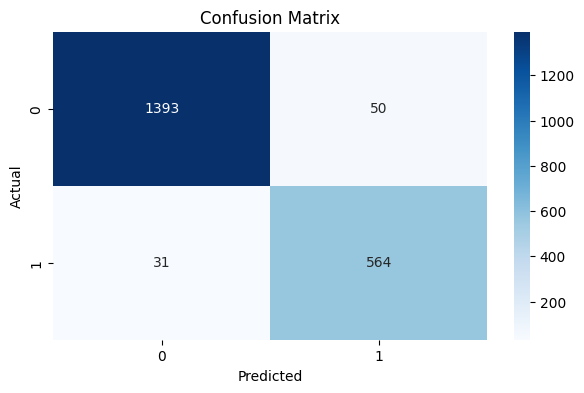

In [16]:
cm = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(7,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Test set predictions

In [17]:
df_test = pl.read_csv('Data/test.csv')

encoded_category = df_test['category'].to_dummies()
print(f"test shape: {df_test.shape}")

df_test = pl.concat([df_test, encoded_category], how = 'horizontal')
df_test = df_test.drop(['category_2'])
print(f"test shape: {df_test.shape}")

#cols_to_drop = ['securities_sold_amt', 'counter_num_inbound', 'counter_num_outbound', 'securities_bought', 'securities_sold']
#df_test_dropped = df_test.drop(cols_to_drop)
#print(f"test shape: {df_test_dropped.shape}")

test shape: (7890, 44)
test shape: (7890, 46)


In [18]:
#prod = [col for col in df_test.columns if col.startswith('product')]
#df_test_dropped_product = df_test_dropped.drop(prod)
#print(f"test shape: {df_test_dropped_product.shape}")

test_df = lagged_table(df_test, 2)
test_df = test_df.filter(pl.col('repays_debt') == '??')
print(f"test shape: {test_df.shape}")

test shape: (718, 132)


In [19]:
X_test = test_df.select([col for col in test_df.columns if col != 'repays_debt'])# and col != 'period' and col != 'client_id'])
y_test = test_df.select(['repays_debt']).to_numpy()

In [20]:
X_test.shape, X.shape

((718, 131), (20376, 131))

In [21]:
X_scaled_test = scaler.transform(X_test)

In [22]:
y_pred_test = model.predict_proba(X_scaled_test)[:, 1]
threshold = 0.2
y_pred_test = (y_pred_test > threshold).astype(int)

In [23]:
np.unique(y_pred_test, return_counts = True)

(array([0, 1]), array([339, 379], dtype=int64))

In [24]:
pd.DataFrame({'Label' : y_pred_test}).to_csv('Predictions/LightGBM-Reduced-Lag2-01Val-threshold02.csv', index = False)

Details:
- subsampled data
- threshold = 0.2 in both cases
- do not drop anything
- 2 lags
- val 0.1